Juypter notebook focusing on the investigation and use of the MS COCO dataset. This was created for CSU's CS445

The goal of this model is to recognize and select cats, dogs, cows, horses, and birds out of a photo

With that in mind we will be developing it specifically for instance segmentation

Contributers: Tucker Laurence, Yasas Wijesekara

In [18]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import urllib
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from collections import Counter
import random
from torch.utils.data import DataLoader
from torchvision import transforms


Global variables used to select conditions about the dataset


In [67]:
annotation_dir='./../annotations'
val_data_name='val2017'
train_data_name='train2017'

val_image_dir = './../datasets/val'
train_image_dir = './../datasets/train'

# relevant_categories = ['cat', 'dog', 'cow', 'horse', 'bird']
relevant_categories = ['dog', 'cat']

This section focuses on the importing and loading of the dataset VIA pycotools.coco, which is the official access tools for MS COCO

In [ ]:
class CocoSegmentationDataset(Dataset):
    """
    PyTorch Dataset for COCO-style instance segmentation tasks.
    if attribute normalize is set to True then any index retrieved sample is normalized

     Args:
        img_dir (str): Path to directory containing images.
        annotation_directory (str): Path to directory with COCO annotation JSON file.
        data_name (str): Name suffix for COCO annotation file.
        relevant_categories (List[str]): List of category names to include.
        transforms (callable, optional): Transformation function to apply to images and targets.
        """
    
    def __init__(self, img_dir, annotation_directory, data_name, relevant_categories, transforms=None):
        # Initialize COCO API and get data during instantiation
        annFile = '{}/instances_{}.json'.format(annotation_directory, data_name)
        self.coco = COCO(annFile)
        self.verbose = True
        
        self.img_dir = img_dir
        self.relevant_categories = relevant_categories
        
        category_ids, image_ids = self._instantiate_ids()

        self.image_ids = image_ids
        self.category_ids = category_ids
        self.transforms = transforms
        
        # Map category_ids to new 1-X labels dynamically
        self.category_to_class_dict = {catagory_id: idx+1 for idx, catagory_id in enumerate(self.category_ids)}
        self.class_to_category_dict = {v: k for k, v in self.category_to_class_dict.items()}
        
        self.normalize = False
        self.normal_image_size = (224,224)
        
    def _instantiate_ids(self):
        category_ids = self.coco.getCatIds(catNms=self.relevant_categories)
        image_ids = []
        
        for category in category_ids:
            temp_img_ids = self.coco.getImgIds(catIds=category)
            image_ids += temp_img_ids
        
        image_ids = list(set(image_ids))
        
        print(f"Found {len(image_ids)} images for {self.relevant_categories}")
        
        return category_ids, image_ids

    def __len__(self):
        """
        Returns:
            int: Number of image samples.
        """
        return len(self.image_ids)

    def __getitem__(self, index):
        """
        Loads a sample image and its corresponding target annotation.

        Args:
            index (int): Index of the sample to load.

        Returns:
            Tuple[Image.Image, Dict]: The image and a dictionary containing 'boxes', 'labels', 'masks', and 'image_id'.
        """
        if self.verbose:
            print(f"Loading item {index}")
            
        img_id = self.image_ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.category_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        masks = []
        boxes = []
        labels = []

        for ann in anns:
            mask = self.coco.annToMask(ann)
            masks.append(mask)

            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])

            original_label = ann['category_id'] #get json label            
            labels.append(self.category_to_class_dict[original_label])  # remapped label using dictionary so that labels contains 1-x classes

        
        #This formatting might need to change
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([img_id]),
        }

        if self.normalize:
            image, target = self._normalize_sample(image, target, new_size=self.normal_image_size)
            
        if self.transforms:
            image, target = self.transforms(image, target)
        else:
            image = transforms.ToTensor()(image)

        return image, target
    
    def _normalize_sample(self, image, target, new_size):
        """
        Resizes image, bounding boxes, and masks to a given size.

        Args:
            image (PIL.Image or torch.Tensor): The image to normalize.
            target (dict): Dictionary containing 'boxes' and 'masks'.
            new_size (Tuple[int, int]): Desired (width, height) for output image and masks.

        Returns:
            Tuple[PIL.Image.Image, Dict]: Resized image and updated target dictionary.
        """
        new_w, new_h = new_size

        if isinstance(image, torch.Tensor):
            old_h, old_w = image.shape[-2], image.shape[-1]
            image = F.to_pil_image(image)
        else:
            old_w, old_h = image.size

        # Resize image
        image = image.resize((new_w, new_h))

        # Scale boxes
        scale_x = new_w / old_w
        scale_y = new_h / old_h
        boxes = target['boxes']
        boxes = boxes.clone()
        boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale_x
        boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale_y
        target['boxes'] = boxes

        # Resize masks
        resized_masks = []
        for mask in target['masks']:
            mask_img = Image.fromarray(mask.numpy())
            resized_mask = mask_img.resize((new_w, new_h), resample=Image.NEAREST)
            resized_masks.append(np.array(resized_mask))
        target['masks'] = torch.as_tensor(np.stack(resized_masks), dtype=torch.uint8)

        return image, target
    
    def _filter_valid_images(self):
        valid_image_ids = []
        for img_id in self.image_ids:
            try:
                img_info = self.coco.loadImgs(img_id)[0]
                img_path = os.path.join(self.img_dir, img_info['file_name'])
                image = Image.open(img_path).convert("RGB")
                ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.category_ids, iscrowd=None)
                anns = self.coco.loadAnns(ann_ids)
                
                # Validate there is at least one valid annotation
                if len(anns) == 0:
                    continue

                # Check for valid masks and bounding boxes
                for ann in anns:
                    _ = self.coco.annToMask(ann)
                    _ = ann['bbox']
                
                valid_image_ids.append(img_id)

            except Exception as e:
                if self.verbose:
                    print(f"Skipping image {img_id} due to error: {e}")
                continue

        print(f"Filtered dataset down to {len(valid_image_ids)} valid images.")
        return valid_image_ids


    
    def download_images(self, verbose=False):
        """
        Downloads COCO images into the specified image directory if they are not already present.

        Args:
            verbose (bool, optional): Whether to print progress messages. Defaults to False.
        """
        current_image_count = 1
        total_image_count = len(self)

        if not os.path.exists(self.img_dir):
            os.makedirs(self.img_dir)

        for img_id in self.image_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            file_name = img_info['file_name']
            url = img_info.get('coco_url')

            img_count_string = f'{current_image_count}/{total_image_count}'

            if url is None:
                print(f"No URL found for image {file_name}, skipping.")
                continue

            save_path = os.path.join(self.img_dir, file_name)
            if not os.path.exists(save_path):
                try:
                    urllib.request.urlretrieve(url, save_path)
                    if verbose: print(f"{img_count_string} Downloaded {file_name}")
                except Exception as e:
                    if verbose:  print(f"{img_count_string} Failed to download {file_name}: {e}")
            else:
                if verbose: print(f"{img_count_string} Image already exists: {file_name}")

            current_image_count += 1

        print(f'Interfaced with {current_image_count-1} unique images')

    def show_data_distribution(self):
        """
        Displays a bar chart of the number of instances per category in the dataset.
        """
        all_labels = []
        category_labels = []
        
        for index in range(len(self)):
            _, target = self.__getitem__(index)
            all_labels.extend(target['labels'].tolist())
        
        for label in all_labels:
            category_labels.append(self.class_to_category_dict[label])

        label_counts = Counter(category_labels)
        category_names = [self.coco.loadCats([catagory_id])[0]['name'] for catagory_id in label_counts.keys()]
        counts = list(label_counts.values())

        plt.figure(figsize=(10, 5))
        plt.bar(category_names, counts, color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Number of Instances')
        plt.title('Category Distribution in Dataset')
        plt.tight_layout()
        plt.show()


This class is used to show the images in a CoCoSegmentationDataset

In [21]:
class ImageVisualizer():
    """
    A helper class to visualize images from a COCO-style segmentation dataset.
    Supports displaying plain images, images with bounding boxes, or with segmentation masks.
    """

    def _plot_image_on_ax(self, dataset: CocoSegmentationDataset, ax, index):
        """
        Plots a plain image from the dataset on the given Matplotlib axis.

        Args:
            dataset (CocoSegmentationDataset): Dataset containing images.
            ax (matplotlib.axes.Axes): Axis on which to draw the image.
            index (int): Index of the image to display.
        """
        image, _ = dataset[index]
        if isinstance(image, torch.Tensor):
            image = F.to_pil_image(image)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"ID: {dataset.image_ids[index]}", fontsize=8)

    def _plot_image_with_boxes_on_ax(self, dataset: CocoSegmentationDataset, ax, index):
        """
        Plots an image with bounding boxes and category labels on the given axis.

        Args:
            dataset (CocoSegmentationDataset): Dataset containing images and annotations.
            ax (matplotlib.axes.Axes): Axis on which to draw.
            index (int): Index of the image to display.
        """
        image, target = dataset[index]
        if isinstance(image, torch.Tensor):
            image = F.to_pil_image(image)

        ax.imshow(image)
        boxes = target['boxes']
        labels = target['labels']
        category_ids = [dataset.class_to_category_dict[label.item()] for label in labels]
        
        category_names = [dataset.coco.loadCats([category_id])[0]['name'] for category_id in category_ids]

        for box, label, category_name in zip(boxes, labels, category_names):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1, category_name, color='white', fontsize=6,
                    bbox=dict(facecolor='red', edgecolor='none', pad=1))
        ax.axis('off')
        ax.set_title(f"ID: {dataset.image_ids[index]}", fontsize=8)

    def _plot_image_with_masks_on_ax(self, dataset: CocoSegmentationDataset, ax, index):
        """
        Plots an image with segmentation masks overlaid on the given axis.

        Args:
            dataset (CocoSegmentationDataset): Dataset containing images and segmentation masks.
            ax (matplotlib.axes.Axes): Axis on which to draw.
            index (int): Index of the image to display.
        """
        image, target = dataset[index]
        if isinstance(image, torch.Tensor):
            image = F.to_pil_image(image)

        ax.imshow(image)
        masks = target['masks'].numpy()
        for mask in masks:
            ax.imshow(mask, alpha=0.4)
        ax.axis('off')
        ax.set_title(f"ID: {dataset.image_ids[index]}", fontsize=8)
    
    def show_images(self, dataset: CocoSegmentationDataset, indices, mode='plain'):
        """
        Displays multiple images from the dataset in a row using the specified visualization mode.

        Args:
            dataset (CocoSegmentationDataset): Dataset containing images and annotations.
            indices (int or list of int): Index/indices of the images to display.
            mode (str): Visualization mode. One of 'plain', 'boxes', or 'masks'.
        """
        if type(indices) == int:
            indices = [indices]
            
        cols = len(indices)
        fig, axs = plt.subplots(1, cols, figsize=(cols * 4, 4))
        
        if cols == 1:
            axs = [axs]

        for ax, idx in zip(axs, indices):
            if mode == 'plain':
                self._plot_image_on_ax(dataset, ax, idx)
            elif mode == 'boxes':
                self._plot_image_with_boxes_on_ax(dataset, ax, idx)
            elif mode == 'masks':
                self._plot_image_with_masks_on_ax(dataset, ax, idx)
            else:
                raise ValueError(f"Unknown mode: {mode}")

        plt.tight_layout()
        plt.show()


In [68]:
#Instantiate the visualizer
# visualizer = ImageVisualizer()

In [75]:
# train_dataset = CocoSegmentationDataset(train_image_dir, annotation_dir, train_data_name, relevant_categories)
val_dataset = CocoSegmentationDataset(val_image_dir, annotation_dir, val_data_name, relevant_categories)

loading annotations into memory...
Done (t=6.61s)
creating index...
index created!
Found 349 images for ['dog', 'cat']


In [76]:
#train_dataset.download_images(verbose=True)
val_dataset.download_images(verbose=True)
val_dataset.image_ids = val_dataset._filter_valid_images()

1/349 Image already exists: 000000245764.jpg
2/349 Image already exists: 000000546829.jpg
3/349 Image already exists: 000000047121.jpg
4/349 Image already exists: 000000411665.jpg
5/349 Image already exists: 000000366611.jpg
6/349 Image already exists: 000000290843.jpg
7/349 Image already exists: 000000061471.jpg
8/349 Image already exists: 000000460841.jpg
9/349 Image already exists: 000000532530.jpg
10/349 Image already exists: 000000446522.jpg
11/349 Image already exists: 000000131131.jpg
12/349 Image already exists: 000000063552.jpg
13/349 Image already exists: 000000149568.jpg
14/349 Image already exists: 000000469067.jpg
15/349 Image already exists: 000000372819.jpg
16/349 Image already exists: 000000327769.jpg
17/349 Image already exists: 000000116825.jpg
18/349 Image already exists: 000000364636.jpg
19/349 Image already exists: 000000532575.jpg
20/349 Image already exists: 000000211042.jpg
21/349 Image already exists: 000000520301.jpg
22/349 Image already exists: 000000157807.j

In [24]:
r_idx = random.randrange(len(val_dataset) - 1)
val_dataset.normalize = True
# visualizer.show_images(val_dataset, r_idx)
# visualizer.show_images(val_dataset, r_idx, mode='boxes')
# visualizer.show_images(val_dataset, r_idx, mode='masks')

# val_dataset.normalize = True
# visualizer.show_images(val_dataset, r_idx)
# visualizer.show_images(val_dataset, r_idx, mode='boxes')
# visualizer.show_images(val_dataset, r_idx, mode='masks')
# val_dataset.normalize = False

In [25]:
# image, target = val_dataset[r_idx]

# print(f"Image shape: {image.shape}")                 # should be [3, H, W]
# print(f"Boxes: {target['boxes'].shape}")             # should be [N, 4]
# print(f"Labels: {target['labels']}")                 # tensor of ints
# print(f"Masks shape: {target['masks'].shape}")       # [N, H, W]
# print(f"Image ID: {target['image_id']}")             # tensor([img_id])
# print(f"Mask Values {torch.unique(target['masks'])}")
# print(target['masks'].dtype)

In [26]:
# val_dataset.show_data_distribution()

Next steps required for data

(Potential, but difficult)
Data augmentation: flipping, rotation, color jitter, pixel normalization, etc

Datasets needs for pre trained models

MODEL 1 Custom Preprocessing and training/test/val

In [27]:
def custom_collate(batch):
    return tuple(zip(*batch))

In [17]:
# val_dataset.verbose = False
# val_dataset.normalize = True

# train_loader = DataLoader(val_dataset, 
#             batch_size=8, 
#             shuffle=True,
#             num_workers=0, 
#             collate_fn=custom_collate
#             )

In [28]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch

def get_instance_segmentation_model(num_classes):
    model = maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model

num_classes = len(relevant_categories) + 1
model = get_instance_segmentation_model(num_classes)


# # Training setup
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model.to(device)

# # Construct optimizer
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005,
#                             momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# # Training loop
# from tqdm import tqdm
# num_epochs = 10

# print("Starting Training")
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, targets in tqdm(train_loader):
#         images = list(img.to(device) for img in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         running_loss += losses.item()

#     lr_scheduler.step()
#     torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
#     print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

In [19]:
# torch.save({
#     'epoch': epoch,
#     'model_state': model.state_dict(),
#     'optimizer_state': optimizer.state_dict(),
#     'scheduler_state': lr_scheduler.state_dict()
# }, 'checkpoint.pth')

In [69]:
"""
num_classes = len(relevant_categories) + 1

model = get_instance_segmentation_model(num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

checkpoint = torch.load("./../models/checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint['model_state'])
"""
num_classes = len(relevant_categories) + 1

model = get_instance_segmentation_model(num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

checkpointcatdog = torch.load("./../models/masrk_rcnn_epoch_10_CatDog.pth", map_location=device)
model.load_state_dict(checkpointcatdog['model_state'])

c:\Users\101083339\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\101083339\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-69-77c42a7a0e6b>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.

<All keys matched successfully>

In [31]:
from PIL import Image
import torchvision.transforms as T
test_image = './../datasets/val/000000007386.jpg' 
image = Image.open(test_image)

Loading item 0
Loading item 1
Loading item 2
Loading item 3
Loading item 4
Loading item 5
Loading item 6
Loading item 7
Loading item 8
Loading item 9
Loading item 10
Loading item 11
Loading item 12
Loading item 13
Loading item 14
Loading item 15
Loading item 16
Loading item 17
Loading item 18
Loading item 19
Loading item 20
Loading item 21
Loading item 22
Loading item 23
Loading item 24
Loading item 25
Loading item 26
Loading item 27
Loading item 28
Loading item 29
Loading item 30
Loading item 31
Loading item 32
Loading item 33
Loading item 34
Loading item 35
Loading item 36
Loading item 37
Loading item 38
Loading item 39
Loading item 40
Loading item 41
Loading item 42
Loading item 43
Loading item 44
Loading item 45
Loading item 46
Loading item 47
Loading item 48
Loading item 49
Loading item 50
Loading item 51
Loading item 52
Loading item 53
Loading item 54
Loading item 55
Loading item 56
Loading item 57
Loading item 58
Loading item 59
Loading item 60
Loading item 61
Loading item 62
Lo

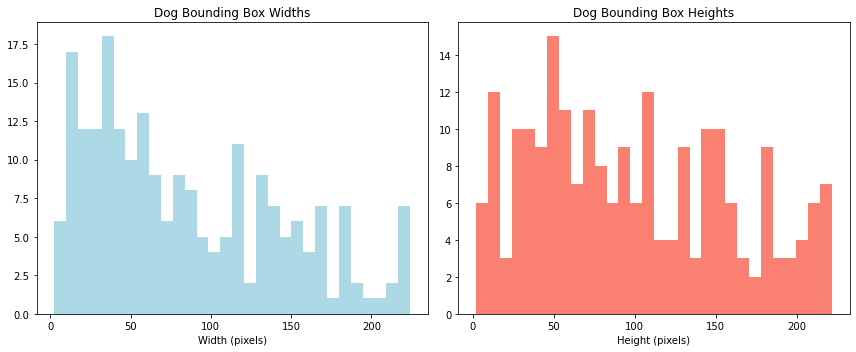

In [32]:
import matplotlib.pyplot as plt

widths, heights = [], []

for i in range(len(val_dataset)):
    _, target = val_dataset[i]
    for box in target['boxes']:
        x1, y1, x2, y2 = box
        widths.append((x2 - x1).item())
        heights.append((y2 - y1).item())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='lightblue')
plt.title("Dog Bounding Box Widths")
plt.xlabel("Width (pixels)")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='salmon')
plt.title("Dog Bounding Box Heights")
plt.xlabel("Height (pixels)")

plt.tight_layout()
plt.show()

Loading item 86


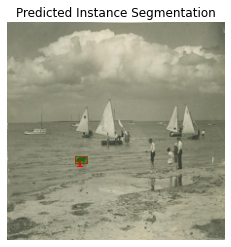

In [33]:
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
import torchvision.transforms.functional as TF

model.eval()
with torch.no_grad():
    r_idx = random.randint(0, len(val_dataset) - 1)
    image, target = val_dataset[r_idx]
    img = image.to(device).unsqueeze(0)
    
    prediction = model(img)[0]

    # Filter masks with confidence threshold
    score_threshold = 0.5
    keep = prediction['scores'] > score_threshold

    masks = prediction['masks'][keep].squeeze(1).cpu()
    boxes = prediction['boxes'][keep].cpu()
    labels = prediction['labels'][keep].cpu()

    drawn = draw_bounding_boxes((image * 255).byte(), boxes, labels=[str(l.item()) for l in labels], colors="red")
    if len(masks) > 0:
        combined_mask = torch.any(masks.bool(), dim=0)
        drawn = draw_segmentation_masks(drawn, combined_mask, alpha=0.4, colors="green")

    plt.imshow(TF.to_pil_image(drawn))
    plt.axis('off')
    plt.title("Predicted Instance Segmentation")
    plt.show()

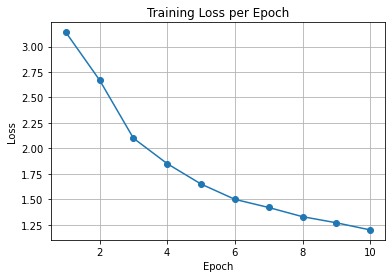

In [34]:
losses_per_epoch = [3.14, 2.67, 2.10, 1.85, 1.65, 1.50, 1.42, 1.33, 1.27, 1.20]  #replace with actual losses

plt.plot(range(1, len(losses_per_epoch) + 1), losses_per_epoch, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()

In [78]:
import json

def coco_format_predictions(model, dataset, relevant_categories, save_path="predictionscatdog.json", score_thresh=0.5):
    """
    Runs inference and saves predictions in COCO format for multiple categories (e.g., cat/dog).
    """
    model.eval()
    results = []

    # Get category IDs from names
    category_ids = dataset.coco.getCatIds(catNms=relevant_categories)
    category_names = {cat['id']: cat['name'] for cat in dataset.coco.loadCats(category_ids)}

    for i in range(len(dataset)):
        try:
            image, _ = dataset[i]
            img_tensor = image.to(device).unsqueeze(0)

            with torch.no_grad():
                prediction = model(img_tensor)[0]

            for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
                if score < score_thresh:
                    continue

                coco_cat_id = dataset.class_to_category_dict.get(label.item())
                if coco_cat_id not in category_ids:
                    continue

                x1, y1, x2, y2 = box
                width = max(x2 - x1, 1)
                height = max(y2 - y1, 1)

                results.append({
                    "image_id": int(dataset.image_ids[i]),
                    "category_id": int(coco_cat_id),
                    "bbox": [float(x1), float(y1), float(width), float(height)],
                    "score": float(score)
                })

        except Exception as e:
            print(f"Skipping image {i} due to error: {e}")
            continue

    with open(save_path, "w") as f:
        json.dump(results, f)

    print(f"Saved {len(results)} predictions to '{save_path}'")
    return save_path

pred_file = coco_format_predictions(model, val_dataset, relevant_categories, score_thresh=0.3)


Loading item 0
Loading item 1
Loading item 2
Loading item 3
Loading item 4
Loading item 5
Loading item 6
Loading item 7
Loading item 8
Loading item 9
Loading item 10
Loading item 11
Loading item 12
Loading item 13
Loading item 14
Loading item 15
Loading item 16
Loading item 17
Loading item 18
Loading item 19
Loading item 20
Loading item 21
Loading item 22
Loading item 23
Loading item 24
Loading item 25
Loading item 26
Loading item 27
Loading item 28
Loading item 29
Loading item 30
Loading item 31
Loading item 32
Loading item 33
Loading item 34
Loading item 35
Loading item 36
Loading item 37
Loading item 38
Loading item 39
Loading item 40
Loading item 41
Loading item 42
Loading item 43
Loading item 44
Loading item 45
Loading item 46
Loading item 47
Loading item 48
Loading item 49
Loading item 50
Loading item 51
Loading item 52
Loading item 53
Loading item 54
Loading item 55
Loading item 56
Loading item 57
Loading item 58
Loading item 59
Loading item 60
Loading item 61
Loading item 62
Lo

Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
🔍 Evaluating AP for 'cat'...
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.45s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.042
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.051
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.272
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.

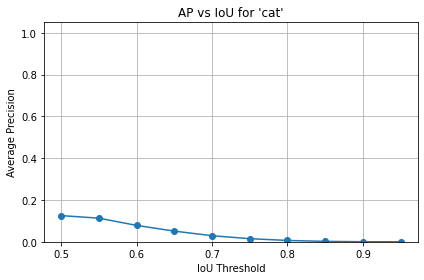

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
🔍 Evaluating AP for 'dog'...
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.012
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.034
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.158
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.201
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.201
 Average Recall     (AR) @[ IoU=0.50:0.

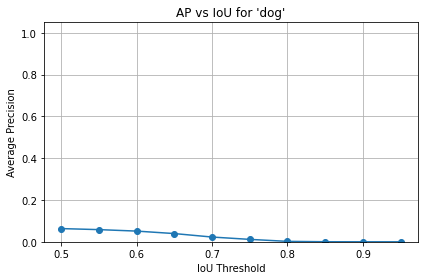

In [79]:
from pycocotools.cocoeval import COCOeval
import matplotlib.pyplot as plt

def map_analysis(dataset, pred_file, category_name):
    """
    Runs COCO evaluation and plots Average Precision vs IoU thresholds for one category.
    """
    coco_gt = dataset.coco
    coco_dt = coco_gt.loadRes(pred_file)

    target_category_id = coco_gt.getCatIds(catNms=[category_name])[0]
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.params.catIds = [target_category_id]
    coco_eval.params.useCats = 1

    print(f"🔍 Evaluating AP for '{category_name}'...")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    if coco_eval.eval is None:
        raise RuntimeError("Evaluation failed — check prediction formatting or score threshold.")

    # Extract average precision for each IoU threshold
    precisions = coco_eval.eval['precision']  # [IoU, Recall, Class, Area, MaxDets]
    ap_vals = precisions[:, :, 0, 0, 2]  # class 0 (since only one in list), area=all, maxDets=100
    ap_per_iou = ap_vals.mean(axis=1)
    iou_thresholds = coco_eval.params.iouThrs

    plt.plot(iou_thresholds, ap_per_iou, marker='o')
    plt.title(f"AP vs IoU for '{category_name}'")
    plt.xlabel("IoU Threshold")
    plt.ylabel("Average Precision")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return coco_eval

coco_eval_cat = map_analysis(val_dataset, pred_file, category_name="cat")
coco_eval_dog = map_analysis(val_dataset, pred_file, category_name="dog")


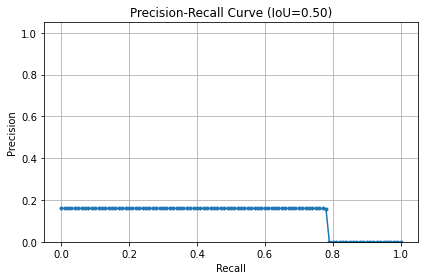

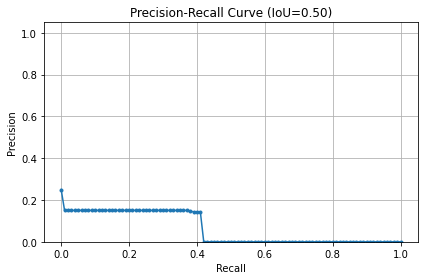

In [80]:
def recall_curve(coco_eval):
    """
    Plots the precision-recall curve for a single evaluated class.
    """
    if coco_eval.eval is None:
        raise ValueError("coco_eval is invalid — did evaluation run successfully?")

    precisions = coco_eval.eval['precision']  # shape: [IoU, Recall, Class, Area, MaxDets]

    # Use IoU = 0.50 (first index), class = 0, area=all, maxDets=100
    pr = precisions[0, :, 0, 0, 2]
    recalls = coco_eval.params.recThrs

    plt.plot(recalls, pr, marker='.')
    plt.title("Precision-Recall Curve (IoU=0.50)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
recall_curve(coco_eval_cat)
recall_curve(coco_eval_dog)

Loading item 0
Loading item 0
Loading item 1
Loading item 1
Loading item 2
Loading item 2
Loading item 3
Loading item 3
Loading item 4
Loading item 4
Loading item 5
Loading item 5
Loading item 6
Loading item 6
Loading item 7
Loading item 7
Loading item 8
Loading item 8
Loading item 9
Loading item 9
Loading item 10
Loading item 10
Loading item 11
Loading item 11
Loading item 12
Loading item 12
Loading item 13
Loading item 13
Loading item 14
Loading item 14
Loading item 15
Loading item 15
Loading item 16
Loading item 16
Loading item 17
Loading item 17
Loading item 18
Loading item 18
Loading item 19
Loading item 19
Loading item 20
Loading item 20
Loading item 21
Loading item 21
Loading item 22
Loading item 22
Loading item 23
Loading item 23
Loading item 24
Loading item 24
Loading item 25
Loading item 25
Loading item 26
Loading item 26
Loading item 27
Loading item 27
Loading item 28
Loading item 28
Loading item 29
Loading item 29
Loading item 30
Loading item 30
Loading item 31
Loading item

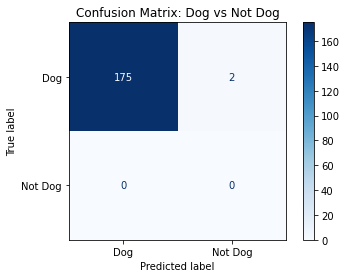

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def conf_matrix(model, dataset, threshold=0.5):
    y_true = []
    y_pred = []

    # COCO category ID for "dog"
    catagory_id = dataset.coco.getCatIds(catNms=["dog"])[0]

    for i in range(len(dataset)):
        try:
            _, target = dataset[i]

            # True label: 1 if "dog" is in ground truth, else 0
            true_labels = [dataset.class_to_category_dict[l.item()] for l in target['labels']]
            y_true.append(1 if catagory_id in true_labels else 0)

            # Predicted: does the model think this is a "dog" image?
            with torch.no_grad():
                img, _ = dataset[i]
                pred = model(img.unsqueeze(0).to(device))[0]

            # Check if any prediction is "dog" above threshold
            pred_labels = [
                dataset.class_to_category_dict.get(l.item()) 
                for l, s in zip(pred['labels'], pred['scores']) 
                if s > threshold
            ]
            y_pred.append(1 if catagory_id in pred_labels else 0)

        except Exception as e:
            print(f"Skipping image {i} due to error: {e}")
            continue

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])  # Rows: actual, Cols: predicted
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dog", "Not Dog"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix: Dog vs Not Dog")
    plt.show()

conf_matrix(model, val_dataset)


Loading item 0
Loading item 1
Loading item 2
Loading item 3
Loading item 4
Loading item 5
Loading item 6
Loading item 7
Loading item 8
Loading item 9
Loading item 10
Loading item 11
Loading item 12
Loading item 13
Loading item 14
Loading item 15
Loading item 16
Loading item 17
Loading item 18
Loading item 19
Loading item 20
Loading item 21
Loading item 22
Loading item 23
Loading item 24
Loading item 25
Loading item 26
Loading item 27
Loading item 28
Loading item 29
Loading item 30
Loading item 31
Loading item 32
Loading item 33
Loading item 34
Loading item 35
Loading item 36
Loading item 37
Loading item 38
Loading item 39
Loading item 40
Loading item 41
Loading item 42
Loading item 43
Loading item 44
Loading item 45
Loading item 46
Loading item 47
Loading item 48
Loading item 49
Loading item 50
Loading item 51
Loading item 52
Loading item 53
Loading item 54
Loading item 55
Loading item 56
Loading item 57
Loading item 58
Loading item 59
Loading item 60
Loading item 61
Loading item 62
Lo

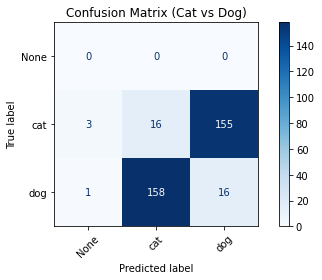

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def conf_matrix_multiclass(model, dataset, threshold=0.5):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []

    # Mapping: category_id → category_name
    id_to_name = {cat['id']: cat['name'] for cat in dataset.coco.loadCats(dataset.category_ids)}

    for i in range(len(dataset)):
        try:
            image, target = dataset[i]  # Load image and its ground truth
            true_ids = [dataset.class_to_category_dict[l.item()] for l in target['labels']]
            true_label = id_to_name[true_ids[0]] if true_ids else "None"
            y_true.append(true_label)

            # Inference
            img_tensor = image.to(device).unsqueeze(0)
            with torch.no_grad():
                prediction = model(img_tensor)[0]

            # Default prediction is "None"
            pred_label = "None"
            top_score = 0

            for label, score in zip(prediction['labels'], prediction['scores']):
                if score >= threshold:
                    cat_id = dataset.class_to_category_dict[label.item()]
                    name = id_to_name.get(cat_id, "None")
                    if score > top_score:
                        pred_label = name
                        top_score = score

            y_pred.append(pred_label)

        except Exception as e:
            print(f"Skipping image {i} due to error: {e}")
            continue

    # Validate prediction counts
    if len(y_pred) != len(y_true):
        print(f"Prediction and ground truth count mismatch: {len(y_pred)} vs {len(y_true)}")
        return

    # Collect all labels seen
    all_labels = sorted(set(y_true + y_pred))

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=all_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix (Cat vs Dog)")
    plt.tight_layout()
    plt.show()

conf_matrix_multiclass(model, val_dataset, threshold=0.3)

In [62]:
from collections import defaultdict
#gets top 10 missclassifications e.g. dog → cat
def misclassifications(model, dataset, threshold=0.5):
    confusion = defaultdict(int)

    for i in range(len(dataset)):
        try:
            _, target = dataset[i]
            true_ids = [dataset.class_to_category_dict[l.item()] for l in target['labels']]

            with torch.no_grad():
                img, _ = dataset[i]
                pred = model(img.unsqueeze(0).to(device))[0]

            for label, score in zip(pred['labels'], pred['scores']):
                if score < threshold:
                    continue

                pred_cat = dataset.class_to_category_dict[label.item()]
                if pred_cat not in true_ids:
                    true_name = dataset.coco.loadCats(true_ids)[0]['name'] if true_ids else "None"
                    pred_name = dataset.coco.loadCats([pred_cat])[0]['name']
                    confusion[(true_name, pred_name)] += 1

        except Exception as e:
            print(f"Error on image {i}: {e}")
            continue

    if not confusion:
        print("No misclassifications found above the given threshold.")
        return

    # Sort and plot
    items = sorted(confusion.items(), key=lambda x: x[1], reverse=True)[:10]
    labels, counts = zip(*items)
    label_names = [f"{t}->{p}" for t, p in labels]

    plt.barh(label_names, counts, color='crimson')
    plt.xlabel("Count")
    plt.title("Top 10 Misclassifications")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
misclassifications(model, val_dataset, threshold=0.3)


Loading item 0
Loading item 0
Loading item 1
Loading item 1
Loading item 2
Loading item 2
Loading item 3
Loading item 3
Loading item 4
Loading item 4
Loading item 5
Loading item 5
Loading item 6
Loading item 6
Loading item 7
Loading item 7
Loading item 8
Loading item 8
Loading item 9
Loading item 9
Loading item 10
Loading item 10
Loading item 11
Loading item 11
Loading item 12
Loading item 12
Loading item 13
Loading item 13
Loading item 14
Loading item 14
Loading item 15
Loading item 15
Loading item 16
Loading item 16
Loading item 17
Loading item 17
Loading item 18
Loading item 18
Loading item 19
Loading item 19
Loading item 20
Loading item 20
Loading item 21
Loading item 21
Loading item 22
Loading item 22
Loading item 23
Loading item 23
Loading item 24
Loading item 24
Loading item 25
Loading item 25
Loading item 26
Loading item 26
Loading item 27
Loading item 27
Loading item 28
Loading item 28
Loading item 29
Loading item 29
Loading item 30
Loading item 30
Loading item 31
Loading item